In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/My Drive/Colab Notebooks/data

In [ ]:
ls

# Imports

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Make Model

---



In [3]:
def make_model():
    base_model = VGG19(include_top=False, input_shape=(150, 150, 3), weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(2048, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x) 
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x) 
    x = Dropout(0.3)(x)
    predictions = Dense(6, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [4]:
make_model().summary()

80142336/80134624 [==============================] - 23s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

# Setting up Input Data Generators

---



In [5]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('acc_vs_epochs.png')

In [6]:
train_path = 'data/train/'

In [7]:
valid_path = 'data/valid/'

No data augmentation for now.

In [8]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=0,
      horizontal_flip=False,
      vertical_flip=False
)

In [9]:
valid_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=0,
      horizontal_flip=False,
      vertical_flip=False
)

In [12]:
train_generator = train_datagen.flow_from_directory(train_path, target_size=(150, 150), 
                                                    batch_size=32, shuffle=True, seed=42)

Found 13627 images belonging to 6 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(valid_path, target_size=(150, 150), 
                                                    batch_size=32, shuffle=True, seed=42)

Found 3407 images belonging to 6 classes.


# Training

---

In [14]:
model = make_model()

In [15]:
model.compile(Adam(lr=0.00001, decay=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
filepath="./checkpoints/" + "VGG16" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint]

In [17]:
history = model.fit_generator(train_generator, 
                              epochs = 10, 
                              steps_per_epoch = 13627 // 32,
                              shuffle = True, 
                              validation_data = valid_generator,
                              validation_steps = 3407 // 32,
                              callbacks = callbacks_list)

Epoch 1/10
425/425 [==============================] - 164s 385ms/step - loss: 3.8635 - acc: 0.4457 - val_loss: 0.4632 - val_acc: 0.8644

Epoch 00001: saving model to ./checkpoints/VGG16_model_weights.h5
Epoch 2/10
425/425 [==============================] - 152s 358ms/step - loss: 1.5604 - acc: 0.6857 - val_loss: 0.3967 - val_acc: 0.8862

Epoch 00002: saving model to ./checkpoints/VGG16_model_weights.h5
Epoch 3/10
425/425 [==============================] - 152s 357ms/step - loss: 1.1105 - acc: 0.7579 - val_loss: 0.3430 - val_acc: 0.8939

Epoch 00003: saving model to ./checkpoints/VGG16_model_weights.h5
Epoch 4/10
425/425 [==============================] - 152s 358ms/step - loss: 0.8681 - acc: 0.8000 - val_loss: 0.3096 - val_acc: 0.9061

Epoch 00004: saving model to ./checkpoints/VGG16_model_weights.h5
Epoch 5/10
425/425 [==============================] - 153s 359ms/step - loss: 0.7323 - acc: 0.8198 - val_loss: 0.3077 - val_acc: 0.9102

Epoch 00005: saving model to ./checkpoints/VGG16_mo

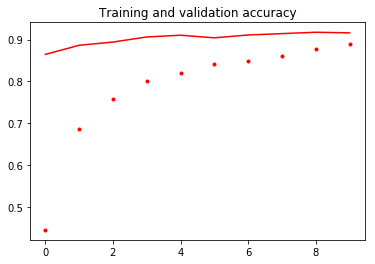

In [18]:
plot_training(history)

In [19]:
import os

In [20]:
test_path = 'data/test'

In [21]:
results = []

In [22]:
for image_name in os.listdir(test_path):
    image_path = test_path + '/' + image_name
    image = load_img(image_path, target_size=(150, 150))
    image = img_to_array(image)
    image = np.array(image)
    image = preprocess_input(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    prediction = np.argmax(model.predict(image))
    results.append({'image_name': image_name, 'label':prediction})

In [23]:
df = pd.DataFrame(results, columns=['image_name', 'label'])

In [24]:
df['label'].value_counts()

3    1321
5    1276
2    1222
4    1191
1    1189
0    1102
Name: label, dtype: int64

In [25]:
df.to_csv("vgg19_big_10epochs_decay.csv", index=False)